## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import make_moons, make_circles, make_classification
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
!pip install lightgbm catboost category_encoders


# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0,)
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

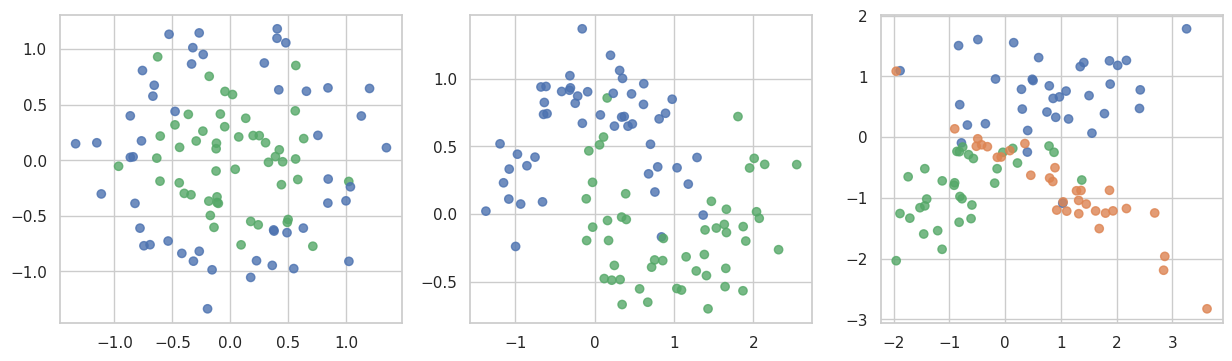

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Ответ:__

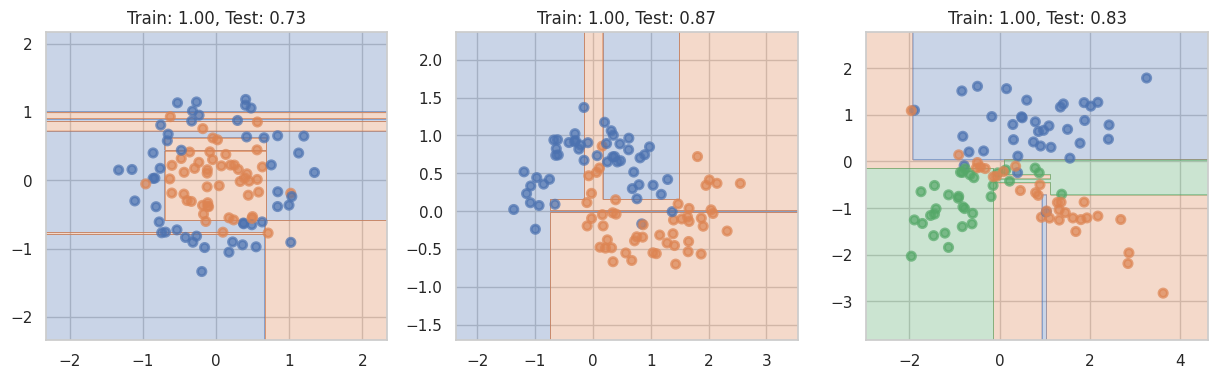

In [ ]:
plt.figure(figsize=(15, 4))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))

    ax = plt.subplot(1, 3, i + 1)
    plot_surface(clf, X, y, ax)
    ax.set_title(f"Train: {train_acc:.2f}, Test: {test_acc:.2f}")
plt.show()

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Ответ:__

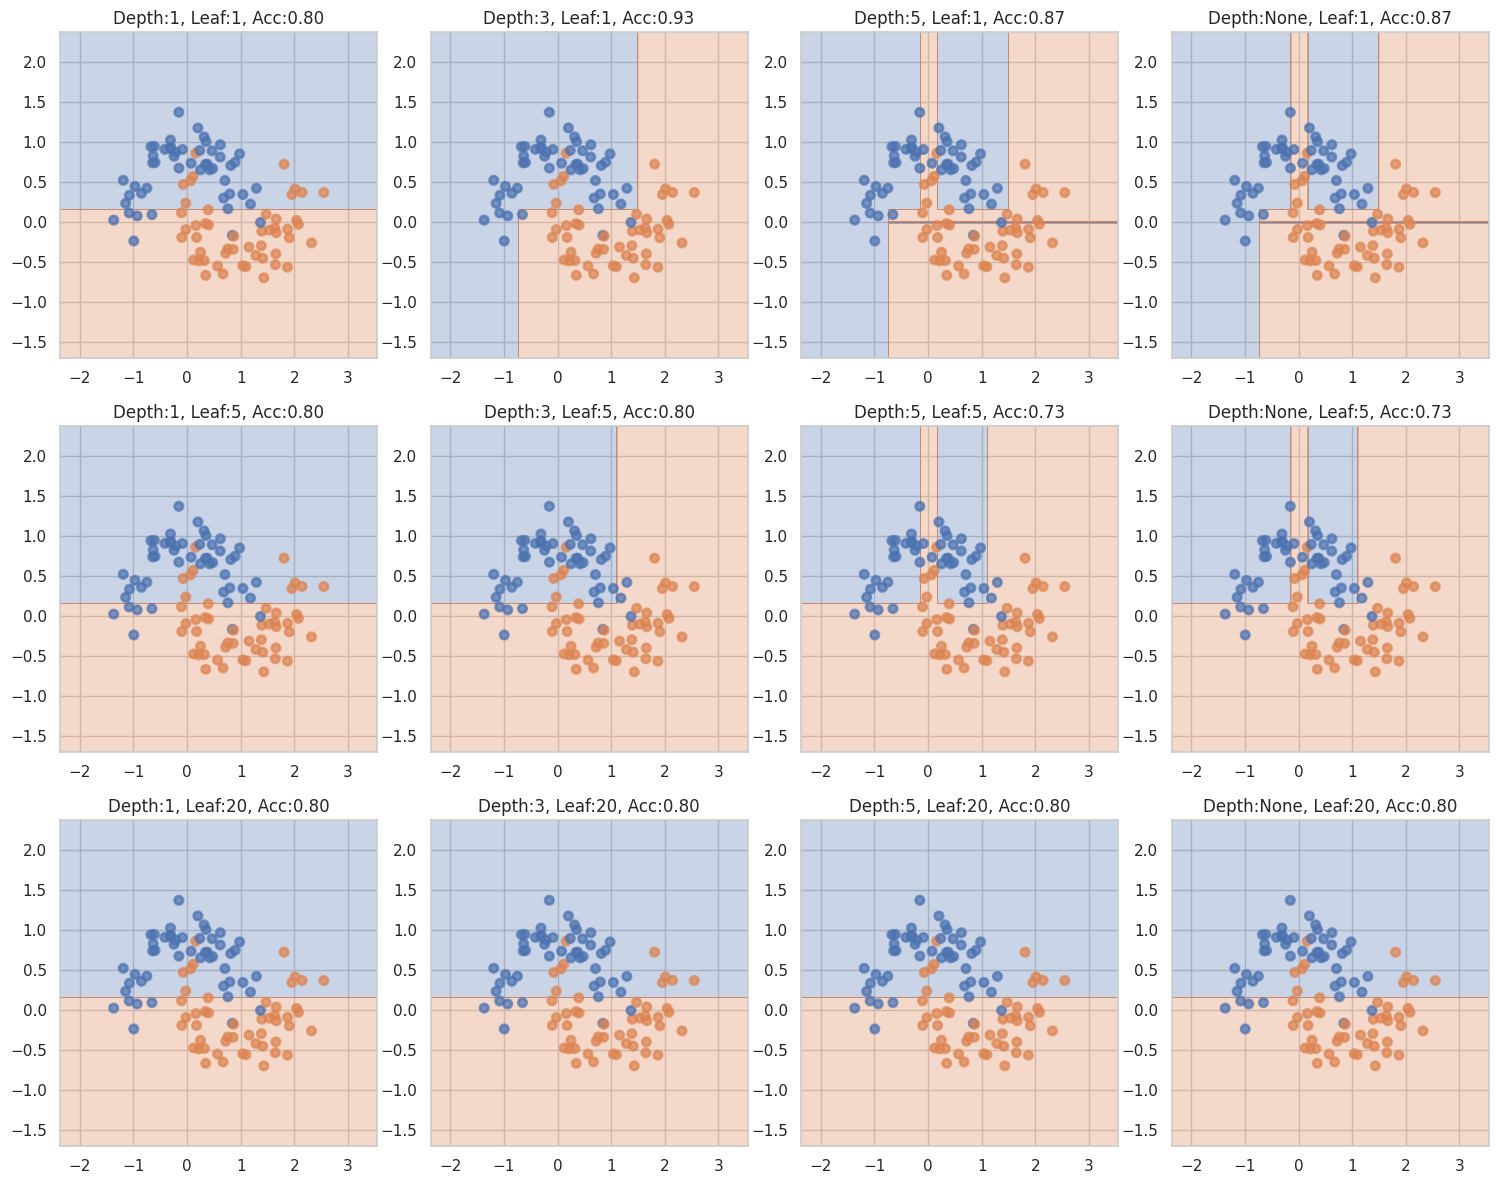

In [ ]:
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_depths = [1, 3, 5, None]
min_samples_leafs = [1, 5, 20]

plt.figure(figsize=(15, 12))
plot_index = 1

for leaf in min_samples_leafs:
    for depth in max_depths:
        clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        clf.fit(X_train, y_train)

        test_acc = accuracy_score(y_test, clf.predict(X_test))

        ax = plt.subplot(len(min_samples_leafs), len(max_depths), plot_index)
        plot_surface(clf, X, y, ax)
        ax.set_title(f"Depth:{depth}, Leaf:{leaf}, Acc:{test_acc:.2f}")
        plot_index += 1
plt.tight_layout()
plt.show()

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
mush_df = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
for col in mush_df.columns:
    mush_df[col] = le.fit_transform(mush_df[col])

X_mush = mush_df.iloc[:, 1:]
y_mush = mush_df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_mush, y_mush, test_size=0.5, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
acc = accuracy_score(y_test, clf.predict(X_test))

print(f"Mushrooms Accuracy (50/50 split): {acc:.4f}")
print(f"Глубина дерева: {clf.get_depth()}")

Mushrooms Accuracy (50/50 split): 1.0000
Глубина дерева: 7


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [113]:

def load_and_prepare_datasets():
    data = {}

    df = pd.read_csv("car.data", header=None)
    data['mushrooms'] = (df.iloc[:, 1:], df.iloc[:, 0]) # X, y

    df = pd.read_csv("tic-tac-toe.data", header=None)
    data['tic-tac-toe'] = (df.iloc[:, :-1], df.iloc[:, -1])

    df = pd.read_csv("car.data", header=None)
    y_raw = df.iloc[:, -1]
    y_bin = y_raw.replace({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    data['cars'] = (df.iloc[:, :-1], y_bin)

    df = pd.read_csv("nursery.data", header=None)
    y_raw = df.iloc[:, -1]
    y_bin = y_raw.replace({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
    data['nursery'] = (df.iloc[:, :-1], y_bin)

    try:
        df = pd.read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN", sheet_name='Training_Data')
        data['user_knowledge'] = (df.iloc[:, :-1], df.iloc[:, -1])
    except:
        print("Не удалось загрузить.")

    return data

datasets_dict = load_and_prepare_datasets()
results = pd.DataFrame(index=datasets_dict.keys(),
                       columns=['Real (LabelEnc)', 'Categorical (LabelEnc)', 'OneHot'])

for name, (X, y) in datasets_dict.items():
    X_le = X.copy()
    cat_cols = X.select_dtypes(include=['object']).columns

    for col in X_le.columns:
        if X_le[col].dtype == 'object':
            X_le[col] = LabelEncoder().fit_transform(X_le[col])

    if y.dtype == 'object':
        y_le = LabelEncoder().fit_transform(y)
    else:
        y_le = y

    if len(cat_cols) > 0:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_ohe = ohe.fit_transform(X[cat_cols])
        num_cols = X.columns.difference(cat_cols)
        if len(num_cols) > 0:
            X_ohe = np.hstack([X_ohe, X[num_cols].values])
    else:
        X_ohe = X_le.values

    clf = DecisionTreeClassifier(random_state=42)
    score_le = cross_val_score(clf, X_le, y_le, cv=10, scoring='accuracy').mean()
    score_cat = score_le

    clf = DecisionTreeClassifier(random_state=42)
    score_ohe = cross_val_score(clf, X_ohe, y_le, cv=10, scoring='accuracy').mean()

    results.loc[name] = [score_le, score_cat, score_ohe]

print("\nAccuracy")
display(results)

Не удалось загрузить.

Accuracy


,Real (LabelEnc),Categorical (LabelEnc),OneHot
mushrooms,0.343195,0.343195,0.345507
tic-tac-toe,0.771678,0.771678,0.805
cars,0.942707,0.942707,0.832454
nursery,0.999691,0.999691,0.999846


__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Best params: {'max_depth': np.int64(11), 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.7079952006980802


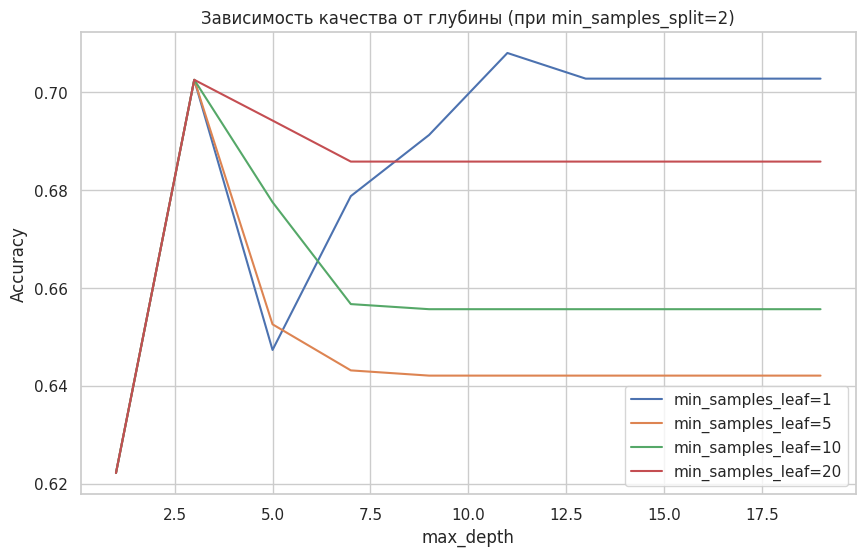

In [112]:
X, y = datasets_dict['tic-tac-toe']

le = LabelEncoder()
y = le.fit_transform(y)
X_le = X.copy()
for col in X.columns:
    X_le[col] = le.fit_transform(X[col])

params = {
    'max_depth': np.arange(1, 20, 2),
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20]
}

clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid.fit(X_le, y)

print(f"Best params: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

plt.figure(figsize=(10, 6))
res = pd.DataFrame(grid.cv_results_)

subset = res[res['param_min_samples_split'] == 2]

for leaf in params['min_samples_leaf']:
    sub_leaf = subset[subset['param_min_samples_leaf'] == leaf]
    plt.plot(sub_leaf['param_max_depth'], sub_leaf['mean_test_score'], label=f'min_samples_leaf={leaf}')

plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Зависимость качества от глубины (при min_samples_split=2)')
plt.legend()
plt.show()

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
data = pd.read_csv('application_train.csv')
print("Dataset loaded successfully.")


if 'SK_ID_CURR' in data.columns:
    data = data.drop(columns=['SK_ID_CURR'])
data['TARGET'] = pd.to_numeric(data['TARGET'], errors='coerce')
data = data.dropna(subset=['TARGET'])

y = data['TARGET']
X = data.drop(columns=['TARGET'])

cat_feats = X.select_dtypes(include=['object']).columns.tolist()
num_feats = X.select_dtypes(exclude=['object']).columns.tolist()

X[num_feats] = X[num_feats].fillna(X[num_feats].median())
X[cat_feats] = X[cat_feats].fillna('missing')

X_num = X[num_feats]

X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=0)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Dataset loaded successfully.
Train shape: (215257, 104), Test shape: (92254, 104)


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [114]:
import lightgbm as lgb
import catboost as cb
import time

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return average_precision_score(y_true, y_pred)

print("Training LightGBM")
start = time.time()
lgb_clf = lgb.LGBMClassifier(random_state=0, force_col_wise=True, verbose=-1)
lgb_clf.fit(X_train, y_train)
lgb_time = time.time() - start
lgb_pred = lgb_clf.predict_proba(X_test)[:, 1]
lgb_score = pr_auc_score(y_test, lgb_pred)


print("Training CatBoost")
start = time.time()
cb_clf = cb.CatBoostClassifier(random_state=0, silent=True, allow_writing_files=False)
cb_clf.fit(X_train, y_train)
cb_time = time.time() - start
cb_pred = cb_clf.predict_proba(X_test)[:, 1]
cb_score = pr_auc_score(y_test, cb_pred)

print(f"LightGBM | Time: {lgb_time:.2f}s | PR-AUC: {lgb_score:.4f}")
print(f"CatBoost | Time: {cb_time:.2f}s | PR-AUC: {cb_score:.4f}")

Training LightGBM
Training CatBoost
LightGBM | Time: 15.18s | PR-AUC: 0.2292
CatBoost | Time: 119.45s | PR-AUC: 0.2324


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, -1],
    'learning_rate': [0.05, 0.1],
    'metric': ['binary_logloss', 'auc']
}

lgb_model = lgb.LGBMClassifier(random_state=0, force_col_wise=True, verbose=-1)

search = RandomizedSearchCV(lgb_model, param_grid, cv=3,
                            scoring='average_precision', n_iter=5, random_state=0, n_jobs=-1)

start = time.time()
search.fit(X_train, y_train)
print(f"Tuning Time: {time.time() - start:.2f}s")
print(f"Best Params: {search.best_params_}")
print(f"Best PR-AUC (CV): {search.best_score_:.4f}")

Tuning Time: 95.61s
Best Params: {'n_estimators': 100, 'metric': 'auc', 'max_depth': -1, 'learning_rate': 0.05}
Best PR-AUC (CV): 0.2321


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [110]:
from scipy.sparse import hstack
from category_encoders import TargetEncoder


X_full = X.copy()
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=0)


X_train_cat_str = X_train_full[cat_feats].astype(str)
X_test_cat_str = X_test_full[cat_feats].astype(str)

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

X_train_ohe_cat = ohe.fit_transform(X_train_cat_str)
X_test_ohe_cat = ohe.transform(X_test_cat_str)

X_train_ohe = hstack([X_train_full[num_feats].values, X_train_ohe_cat])
X_test_ohe = hstack([X_test_full[num_feats].values, X_test_ohe_cat])

te = TargetEncoder(cols=cat_feats, smoothing=10)


X_train_te = te.fit_transform(X_train_full, y_train)
X_test_te = te.transform(X_test_full)

print("LGBM with OHE")
start = time.time()
lgb_ohe = lgb.LGBMClassifier(random_state=0, force_col_wise=True, verbose=-1)
lgb_ohe.fit(X_train_ohe, y_train)
print(f"Time: {time.time() - start:.2f}s")

print(f"Score: {pr_auc_score(y_test, lgb_ohe.predict_proba(X_test_ohe)[:, 1]):.4f}")


print("LGBM with TE")
start = time.time()
lgb_te = lgb.LGBMClassifier(random_state=0, force_col_wise=True, verbose=-1)
lgb_te.fit(X_train_te, y_train)
print(f"Time: {time.time() - start:.2f}s")

print(f"Score: {pr_auc_score(y_test, lgb_te.predict_proba(X_test_te)[:, 1]):.4f}")

LGBM with OHE
Time: 17.85s
Score: 0.2350
LGBM with TE
Time: 20.42s
Score: 0.2352


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [109]:
pred_ohe = lgb_ohe.predict_proba(X_test_ohe)[:, 1]
pred_te = lgb_te.predict_proba(X_test_te)[:, 1]

blend_pred = (pred_ohe + pred_te) / 2
blend_score = pr_auc_score(y_test, blend_pred)

print(f"Blending Score {blend_score:.4f}")

Blending Score 0.2361


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

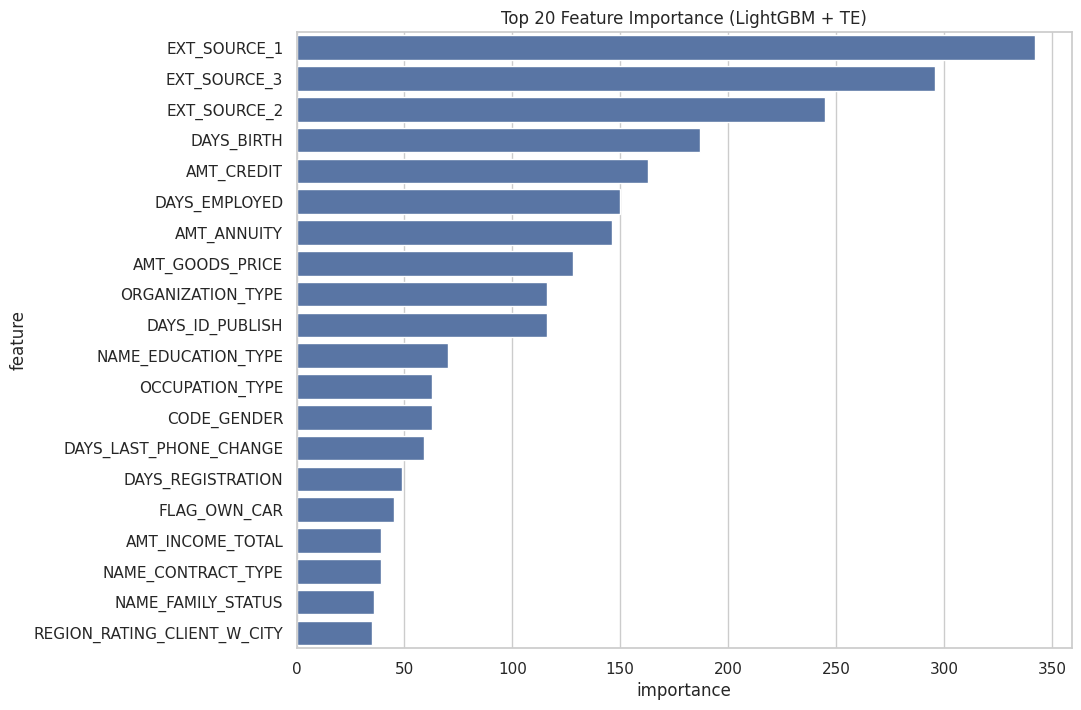

Zero importance features: 29
Retraining without zero-importance features...
Reduced Score: 0.2352


In [ ]:
importance = lgb_te.feature_importances_
feature_names = X_train_te.columns

df_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
df_imp = df_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_imp.head(20))
plt.title('Top 20 Feature Importance (LightGBM + TE)')
plt.show()

low_imp_feats = df_imp[df_imp['importance'] == 0]['feature'].tolist()
print(f"Zero importance features: {len(low_imp_feats)}")

if len(low_imp_feats) > 0:
    print("Retraining without zero-importance features...")
    X_train_red = X_train_te.drop(columns=low_imp_feats)
    X_test_red = X_test_te.drop(columns=low_imp_feats)

    lgb_red = lgb.LGBMClassifier(random_state=0, force_col_wise=True, verbose=-1)
    lgb_red.fit(X_train_red, y_train)
    red_score = pr_auc_score(y_test, lgb_red.predict_proba(X_test_red)[:, 1])
    print(f"Reduced Score: {red_score:.4f}")